In [1]:
import os, cv2, math, gc
import numpy as np
import pandas as pd
from tqdm import tqdm

IMG_SIZE = (380, 380)
SEED = 42
np.random.seed(SEED)


In [2]:
def apply_clahe_color(img_bgr):
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    return cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)

In [3]:
def circular_crop(img_bgr):
    # Grayscale + seuillage pour détecter le disque
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    # Normalisation légère pour stabiliser
    g = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)
    # Mask = pixels “non noirs”
    _, mask = cv2.threshold(g, 5, 255, cv2.THRESH_BINARY)
    ys, xs = np.where(mask > 0)
    if len(xs) < 10:  # fallback si image bizarre
        h, w = gray.shape[:2]
        r = min(h, w)//2
        cx, cy = w//2, h//2
    else:
        # centre ~ médiane des points non-noirs
        cx, cy = int(np.median(xs)), int(np.median(ys))
        # rayon = max distance au centre parmi les points non-noirs
        r = int(np.max(np.sqrt((xs - cx)**2 + (ys - cy)**2)))
        # borne dans l'image
        h, w = gray.shape[:2]
        r = max(1, min(r, cx, cy, w - cx, h - cy))

    # découpe carré englobant le disque
    x1, x2 = cx - r, cx + r
    y1, y2 = cy - r, cy + r
    h, w = gray.shape[:2]
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w, x2), min(h, y2)
    crop = img_bgr[y1:y2, x1:x2]
    return crop


In [4]:
def preprocess_image(path, img_size=IMG_SIZE):
    img = cv2.imread(path)
    if img is None:
        return None
    img = circular_crop(img)
    img = apply_clahe_color(img)
    img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0
    return img


In [5]:
def build_npz_from_df(df, img_dir, out_path, img_size=IMG_SIZE, ext_preferred=None):
    X, y = [], []
    missing = 0

    for _, row in tqdm(df.iterrows(), total=len(df)):
        fname = str(row["filename"])
        label = int(row["label"])

        # si le nom n'a pas d'extension, on essaie ext_preferred puis .png/.jpg
        base, ext = os.path.splitext(fname)
        if ext == "":
            tried = []
            if ext_preferred:
                tried.append(base + ext_preferred)
            tried += [base + ".png", base + ".jpg", base + ".jpeg", base + ".JPG", base + ".PNG"]
            img_path = None
            for t in tried:
                p = os.path.join(img_dir, t)
                if os.path.exists(p):
                    img_path = p
                    break
        else:
            img_path = os.path.join(img_dir, fname) if os.path.exists(os.path.join(img_dir, fname)) else None

        if img_path is None:
            missing += 1
            continue

        img = preprocess_image(img_path, img_size=img_size)
        if img is None:
            missing += 1
            continue

        X.append(img)
        y.append(label)

    if len(X) == 0:
        raise RuntimeError("Aucune image valide trouvée. Vérifie les chemins/colonnes.")

    X = np.stack(X, axis=0)
    y = np.array(y, dtype=np.int64)

    np.savez(out_path, X=X, y=y)
    print(f"✅ Sauvé: {out_path} | X={X.shape} y={y.shape} | manquantes: {missing}")
    gc.collect()
    return X, y


In [9]:
aptos_csv = r"../data/train_1.csv"
aptos_img_dir = r"../data/train_images"

df_aptos = (
    pd.read_csv(aptos_csv)[["id_code", "diagnosis"]]
      .rename(columns={"id_code": "filename", "diagnosis": "label"})
)

print(df_aptos.head())


       filename  label
0  1ae8c165fd53      2
1  1b329a127307      1
2  1b32e1d775ea      4
3  1b3647865779      0
4  1b398c0494d1      0


In [11]:
messidor_csv = r"../data/messidor_data.csv"
messidor_img_dir = r"../data/messidor"
df_messidor_raw = pd.read_csv(messidor_csv)

df_messidor = pd.DataFrame({
    "filename": df_messidor_raw["id_code"].astype(str) + ".png",
    "label":    df_messidor_raw["diagnosis"].astype(int)
})


In [17]:
idrid_train_csv = r"../data/IDRiD/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv"
idrid_train_img_dir = r"../data/IDRiD/1. Original Images/a. Training Set"

df_idrid_train_raw = pd.read_csv(idrid_train_csv)

print("Colonnes :", df_idrid_train_raw.columns.tolist())
print(df_idrid_train_raw.head())

df_idrid_train = pd.DataFrame({
    "filename": df_idrid_train_raw["Image name"].astype(str) + ".jpg",
    "label":    df_idrid_train_raw["Retinopathy grade"].astype(int)
})

df_idrid_train["filepath"] = df_idrid_train["filename"].apply(lambda f: os.path.join(idrid_train_img_dir, f))
df_idrid_train["exists"] = df_idrid_train["filepath"].apply(os.path.exists)

print(df_idrid_train.head())
print("Images trouvées :", df_idrid_train["exists"].sum(), "/", len(df_idrid_train))


Colonnes : ['Image name', 'Retinopathy grade', 'Risk of macular edema ', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11']
  Image name  Retinopathy grade  Risk of macular edema   Unnamed: 3  \
0  IDRiD_001                  3                       2         NaN   
1  IDRiD_002                  3                       2         NaN   
2  IDRiD_003                  2                       2         NaN   
3  IDRiD_004                  3                       2         NaN   
4  IDRiD_005                  4                       0         NaN   

   Unnamed: 4  Unnamed: 5  Unnamed: 6  Unnamed: 7  Unnamed: 8  Unnamed: 9  \
0         NaN         NaN         NaN         NaN         NaN         NaN   
1         NaN         NaN         NaN         NaN         NaN         NaN   
2         NaN         NaN         NaN         NaN         NaN         NaN   
3         NaN         NaN         NaN         NaN         NaN   

In [22]:
df_aptos = audit_and_fix_df(df_aptos, aptos_img_dir)         
X_aptos, y_aptos = build_npz_from_df(df_aptos, "../data/processed_aptos_unified.npz", IMG_SIZE)

df_messidor = audit_and_fix_df(df_messidor, messidor_img_dir) 
X_mess, y_mess = build_npz_from_df(df_messidor, "../data/processed_messidor_unified.npz", IMG_SIZE)

df_idrid_train = audit_and_fix_df(df_idrid_train, idrid_train_img_dir)
X_idr, y_idr = build_npz_from_df(df_idrid_train, "../data/processed_idrid_train_unified.npz", IMG_SIZE)


📂 Dossier: ../data/train_images
Fichiers indexés: 2930   |   Lignes DF: 2930   |   Matchés: 2930


100%|██████████| 2930/2930 [03:56<00:00, 12.38it/s]


✅ Sauvé: ../data/processed_aptos_unified.npz  |  X:(2930, 224, 224, 3)  y:(2930,)  |  classes:{np.int64(0): 1434, np.int64(1): 300, np.int64(2): 808, np.int64(3): 154, np.int64(4): 234}
📂 Dossier: ../data/messidor
Fichiers indexés: 1744   |   Lignes DF: 1744   |   Matchés: 1744


100%|██████████| 1744/1744 [00:18<00:00, 95.97it/s] 


✅ Sauvé: ../data/processed_messidor_unified.npz  |  X:(1744, 224, 224, 3)  y:(1744,)  |  classes:{np.int64(0): 1017, np.int64(1): 270, np.int64(2): 347, np.int64(3): 75, np.int64(4): 35}
📂 Dossier: ../data/IDRiD/1. Original Images/a. Training Set
Fichiers indexés: 413   |   Lignes DF: 413   |   Matchés: 413


100%|██████████| 413/413 [00:29<00:00, 14.13it/s]


✅ Sauvé: ../data/processed_idrid_train_unified.npz  |  X:(413, 224, 224, 3)  y:(413,)  |  classes:{np.int64(0): 134, np.int64(1): 20, np.int64(2): 136, np.int64(3): 74, np.int64(4): 49}


In [23]:
def combine_npz(paths, out_path):
    Xs, ys = [], []
    for p in paths:
        d = np.load(p)
        Xs.append(d["X"])
        ys.append(d["y"])
    X = np.concatenate(Xs, axis=0)
    y = np.concatenate(ys, axis=0)
    np.savez(out_path, X=X, y=y)
    print(f"✅ Combined saved to {out_path} | X={X.shape} y={y.shape}")
    return X, y

combined_path = r"../data/combined_unified.npz"
X_comb, y_comb = combine_npz(
    [
        r"../data/processed_aptos_unified.npz",
        r"../data/processed_messidor_unified.npz",
        r"../data/processed_idrid_train_unified.npz"
    ],
    combined_path
)


✅ Combined saved to ../data/combined_unified.npz | X=(5087, 224, 224, 3) y=(5087,)


APTOS : (2930, 224, 224, 3) (2930,)  | unique y: [0 1 2 3 4]
MESSIDOR : (1744, 224, 224, 3) (1744,)  | unique y: [0 1 2 3 4]
IDRiD : (413, 224, 224, 3) (413,)  | unique y: [0 1 2 3 4]
COMBINED : (5087, 224, 224, 3) (5087,)  | unique y: [0 1 2 3 4]


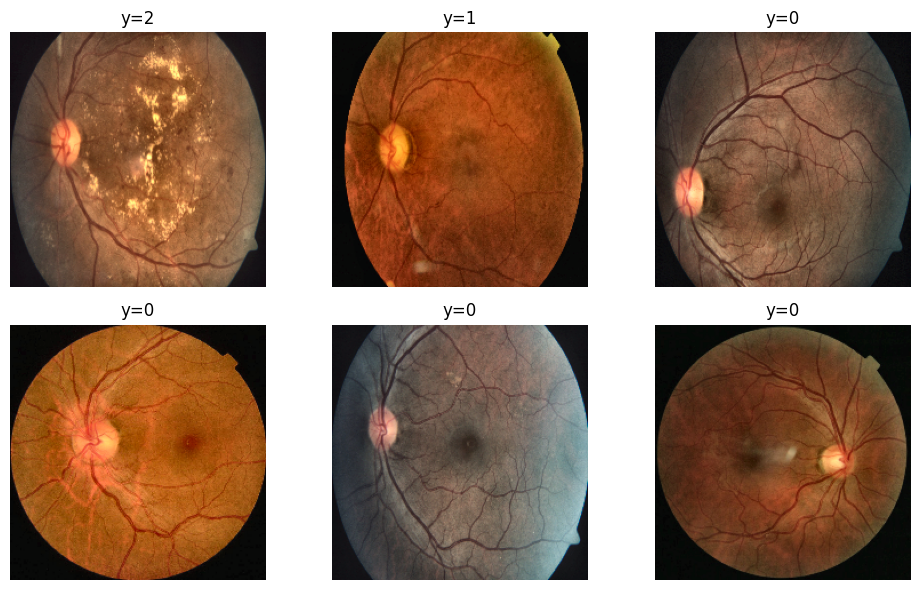

In [24]:
print("APTOS :", X_aptos.shape, y_aptos.shape, " | unique y:", np.unique(y_aptos))
print("MESSIDOR :", X_mess.shape, y_mess.shape, " | unique y:", np.unique(y_mess))
print("IDRiD :", X_idr.shape, y_idr.shape, " | unique y:", np.unique(y_idr))
print("COMBINED :", X_comb.shape, y_comb.shape, " | unique y:", np.unique(y_comb))

import matplotlib.pyplot as plt
idx = np.random.choice(len(X_comb), size=6, replace=False)
plt.figure(figsize=(10,6))
for i, k in enumerate(idx, 1):
    plt.subplot(2,3,i); plt.imshow(cv2.cvtColor((X_comb[k]*255).astype(np.uint8), cv2.COLOR_BGR2RGB))
    plt.title(f"y={int(y_comb[k])}"); plt.axis("off")
plt.tight_layout(); plt.show()
